In [1]:
!pip install pandas scikit-learn

In [11]:

from google.colab import files
uploaded = files.upload()

Saving demo.XPT to demo.XPT
Saving glu.XPT to glu.XPT


In [2]:
import pandas as pd

# Example for loading datasets
demo = pd.read_csv("path_to_demographics_data.csv")
glu = pd.read_csv("path_to_glucose_data.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_demographics_data.csv'

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Step 1: Load and merge datasets on 'SEQN'
merged_data = pd.merge(demo, glu[['SEQN', 'LBXGLU']], on='SEQN', how='inner')

# Step 2: Create a target label (diabetes status)
merged_data['diabetes_status'] = merged_data['LBXGLU'].apply(lambda x: 1 if x >= 126 else 0)

# Step 3: Handle missing values
numerical_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = merged_data.select_dtypes(exclude=['float64', 'int64']).columns

# Impute missing values for numerical columns
for col in numerical_cols:
    merged_data[col] = merged_data[col].fillna(merged_data[col].mean())

# Impute missing values for categorical columns
for col in categorical_cols:
    merged_data[col] = merged_data[col].fillna(merged_data[col].mode()[0])

# Step 4: Prepare features and target
X = merged_data.drop(columns=['SEQN', 'diabetes_status', 'LBXGLU'], errors='ignore')
y = merged_data['diabetes_status']

# Encode categorical variables (if any)
X = pd.get_dummies(X, drop_first=True)

# Step 5: Handle remaining missing values (if any) using SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Before applying the imputer, let's check for any columns with all missing values
X = X.loc[:, X.isnull().mean() < 1]  # Drop columns where all values are NaN

# Impute missing values for the remaining columns
X_imputed = imputer.fit_transform(X)

# Make sure the DataFrame column names are retained after transformation
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# Step 6: Split the data into training and testing sets (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X_imputed_df, y, test_size=0.2, random_state=42)

# Step 7: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Recursive Feature Elimination (RFE)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=log_reg, n_features_to_select=10)  # Select top 5 features
rfe.fit(X_train_scaled, y_train)
rfe_selected_features = X_imputed_df.columns[rfe.support_].tolist()

# Step 9: Principal Component Analysis (PCA)
pca = PCA(n_components=5)  # Reduce to 5 principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
pca_selected_features = [f"PC{i+1}" for i in range(pca.n_components_)]

# Print selected features
print("RFE Selected Features:", rfe_selected_features)
print("PCA Components:", pca_selected_features)


NameError: name 'demo' is not defined

In [8]:
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, roc_auc_score
)
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Confusion Matrix Plotting Function
def plot_confusion_matrix(cm, classes, description="Confusion Matrix"):
    """
    Plots a confusion matrix using Seaborn heatmap.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"{description}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Function to train and evaluate a Decision Tree model with extended metrics
def train_and_evaluate(X_train, X_test, y_train, y_test, description):
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)

    # If probabilities are needed for AUC, GI, etc.
    y_prob = decision_tree.predict_proba(X_test)[:, 1] if hasattr(decision_tree, "predict_proba") else None

    # Evaluate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Basic Metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0    # Precision

    # Gini Index and AUC
    gini_index = 2 * roc_auc_score(y_test, y_prob) - 1 if y_prob is not None else "N/A"
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    auch = auc  # Area Under Convex Hull approximated as AUC

    # Misclassification Error Rate (MER)
    mer = 1 - accuracy

    # Matthews Correlation Coefficient (MWC)
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mwc = numerator / denominator if denominator != 0 else 0

    # Print Results
    print(f"Results for {description}:")
    print("Accuracy:", round(accuracy, 3))
    print("Sensitivity (TPR):", round(sensitivity, 3))
    print("Specificity (TNR):", round(specificity, 3))
    print("Precision (PPV):", round(precision, 3))
    print("Gini Index:", gini_index)
    print("AUC:", auc)
    print("AUCH (approx):", auch)
    print("MER:", round(mer, 3))
    print("MWC:", round(mwc, 3))
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\n" + "=" * 50 + "\n")

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, classes=["Class 0", "Class 1"], description=description)

# Train and Evaluate without PCA
train_and_evaluate(X_train_scaled, X_test_scaled, y_train, y_test, "Without PCA")

# Train and Evaluate with PCA for 5, 10, 15, and 20 components
for n_components in [5, 10, 15, 20, 25]:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    description = f"With PCA ({n_components} components)"
    train_and_evaluate(X_train_pca, X_test_pca, y_train, y_test, description)


NameError: name 'X_train_scaled' is not defined

Results for Without PCA:
Accuracy: 0.821
Sensitivity (TPR): 0.088
Specificity (TNR): 0.915
Precision (PPV): 0.118
Gini Index: 0.04319657775229002
AUC: 0.521598288876145
AUCH (approx): 0.521598288876145
MER: 0.179
MWC: 0.004

Confusion Matrix:
 [[649  60]
 [ 83   8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       709
           1       0.12      0.09      0.10        91

    accuracy                           0.82       800
   macro avg       0.50      0.50      0.50       800
weighted avg       0.80      0.82      0.81       800





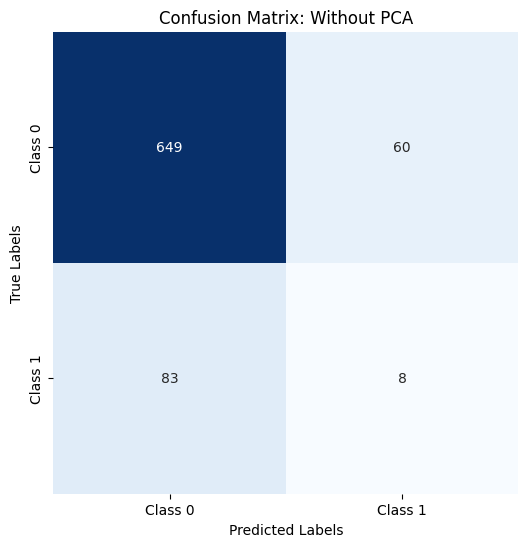

Results for With PCA (5 components):
Accuracy: 0.821
Sensitivity (TPR): 0.099
Specificity (TNR): 0.914
Precision (PPV): 0.129
Gini Index: 0.054619569429160464
AUC: 0.5273097847145802
AUCH (approx): 0.5273097847145802
MER: 0.179
MWC: 0.014

Confusion Matrix:
 [[648  61]
 [ 82   9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       709
           1       0.13      0.10      0.11        91

    accuracy                           0.82       800
   macro avg       0.51      0.51      0.51       800
weighted avg       0.80      0.82      0.81       800





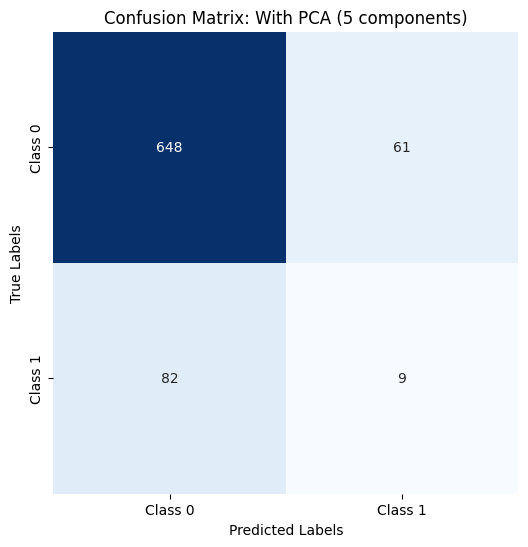

Results for With PCA (10 components):
Accuracy: 0.819
Sensitivity (TPR): 0.121
Specificity (TNR): 0.908
Precision (PPV): 0.145
Gini Index: 0.07272276383700937
AUC: 0.5363613819185047
AUCH (approx): 0.5363613819185047
MER: 0.181
MWC: 0.032

Confusion Matrix:
 [[644  65]
 [ 80  11]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       709
           1       0.14      0.12      0.13        91

    accuracy                           0.82       800
   macro avg       0.52      0.51      0.52       800
weighted avg       0.80      0.82      0.81       800





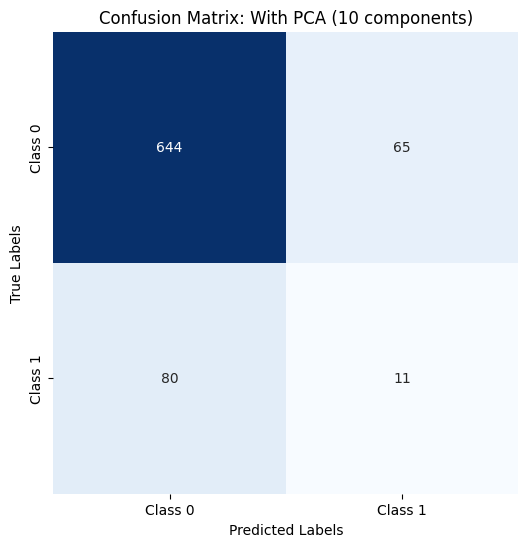

Results for With PCA (15 components):
Accuracy: 0.791
Sensitivity (TPR): 0.088
Specificity (TNR): 0.882
Precision (PPV): 0.087
Gini Index: 0.0011624482710519413
AUC: 0.500581224135526
AUCH (approx): 0.500581224135526
MER: 0.209
MWC: -0.03

Confusion Matrix:
 [[625  84]
 [ 83   8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       709
           1       0.09      0.09      0.09        91

    accuracy                           0.79       800
   macro avg       0.48      0.48      0.48       800
weighted avg       0.79      0.79      0.79       800





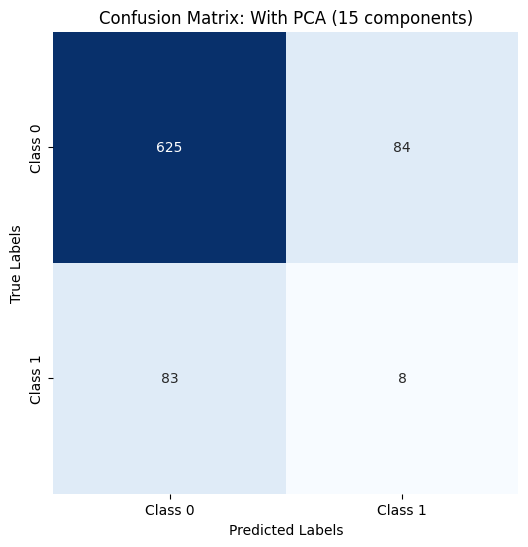

Results for With PCA (20 components):
Accuracy: 0.82
Sensitivity (TPR): 0.121
Specificity (TNR): 0.91
Precision (PPV): 0.147
Gini Index: 0.07571413072118305
AUC: 0.5378570653605915
AUCH (approx): 0.5378570653605915
MER: 0.18
MWC: 0.033

Confusion Matrix:
 [[645  64]
 [ 80  11]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       709
           1       0.15      0.12      0.13        91

    accuracy                           0.82       800
   macro avg       0.52      0.52      0.52       800
weighted avg       0.81      0.82      0.81       800





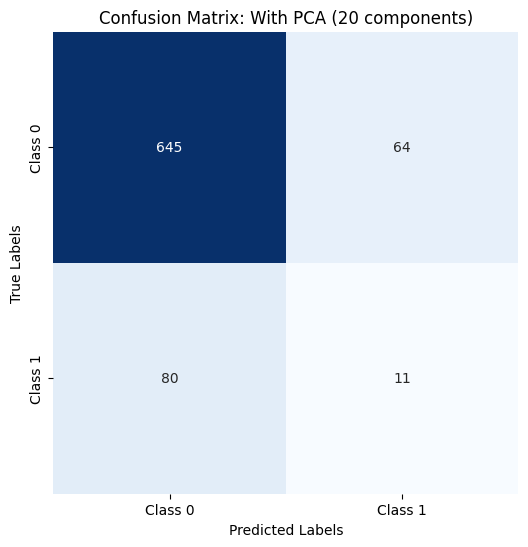

Results for With PCA (25 components):
Accuracy: 0.807
Sensitivity (TPR): 0.154
Specificity (TNR): 0.891
Precision (PPV): 0.154
Gini Index: 0.0924688851346116
AUC: 0.5462344425673058
AUCH (approx): 0.5462344425673058
MER: 0.193
MWC: 0.045

Confusion Matrix:
 [[632  77]
 [ 77  14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       709
           1       0.15      0.15      0.15        91

    accuracy                           0.81       800
   macro avg       0.52      0.52      0.52       800
weighted avg       0.81      0.81      0.81       800





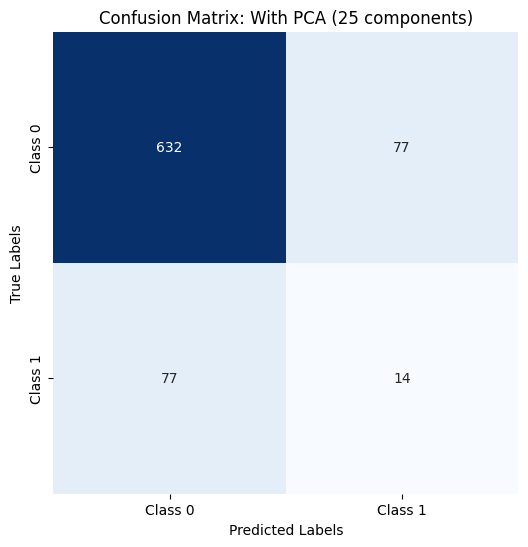

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, description):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix: {description}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Function to train and evaluate a Decision Tree model with extended metrics
def train_and_evaluate(X_train, X_test, y_train, y_test, description):
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)

    # If probabilities are needed for AUC, GI, etc.
    y_prob = decision_tree.predict_proba(X_test)[:, 1] if hasattr(decision_tree, "predict_proba") else None

    # Evaluate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Basic Metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0    # Precision

    # Gini Index and AUC
    gini_index = 2 * roc_auc_score(y_test, y_prob) - 1 if y_prob is not None else "N/A"
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    auch = auc  # Area Under Convex Hull approximated as AUC

    # Misclassification Error Rate (MER)
    mer = 1 - accuracy

    # Matthews Correlation Coefficient (MWC)
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mwc = numerator / denominator if denominator != 0 else 0

    # Print Results
    print(f"Results for {description}:")
    print("Accuracy:", round(accuracy, 3))
    print("Sensitivity (TPR):", round(sensitivity, 3))
    print("Specificity (TNR):", round(specificity, 3))
    print("Precision (PPV):", round(precision, 3))
    print("Gini Index:", gini_index)
    print("AUC:", auc)
    print("AUCH (approx):", auch)
    print("MER:", round(mer, 3))
    print("MWC:", round(mwc, 3))
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\n" + "="*50 + "\n")

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=["Class 0", "Class 1"], description=description)

# Train and Evaluate without PCA
train_and_evaluate(X_train_scaled, X_test_scaled, y_train, y_test, "Without PCA")

# Train and Evaluate with PCA for 5, 10, 15, and 20 components
for n_components in [5, 10, 15, 20, 25]:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    description = f"With PCA ({n_components} components)"
    train_and_evaluate(X_train_pca, X_test_pca, y_train, y_test, description)



Metrics for Decision Tree:
Accuracy: 0.821
Sensitivity: 0.088
Specificity: 0.915
Precision: 0.118
Gini Index: 0.04319657775229002
AUC: 0.521598288876145
MER: 0.179

Metrics for Decision Tree:
Accuracy: 0.821
Sensitivity (TPR): 0.088
Specificity (TNR): 0.915
Precision (PPV): 0.118
Gini Index: 0.04319657775229002
AUC: 0.521598288876145
MER: 0.179

Confusion Matrix:
 [[649  60]
 [ 83   8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       709
           1       0.12      0.09      0.10        91

    accuracy                           0.82       800
   macro avg       0.50      0.50      0.50       800
weighted avg       0.80      0.82      0.81       800



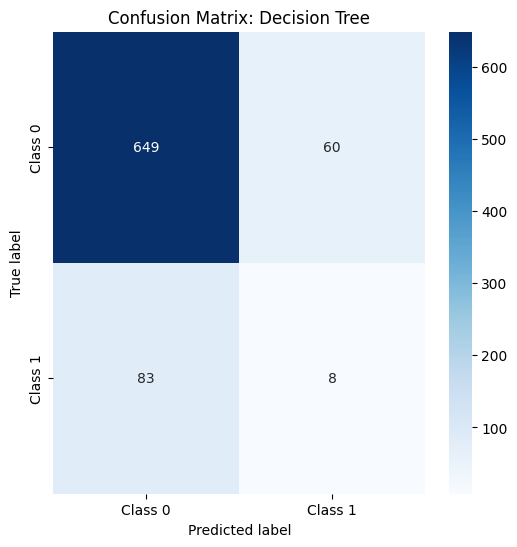

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8352 - loss: 0.4883
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9005 - loss: 0.3169
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8972 - loss: 0.2981
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8934 - loss: 0.2912
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9011 - loss: 0.2613
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9066 - loss: 0.2470
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9210 - loss: 0.2210
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.2149
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2016
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9406 - loss: 0.1752
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9439 - loss: 0.1622
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

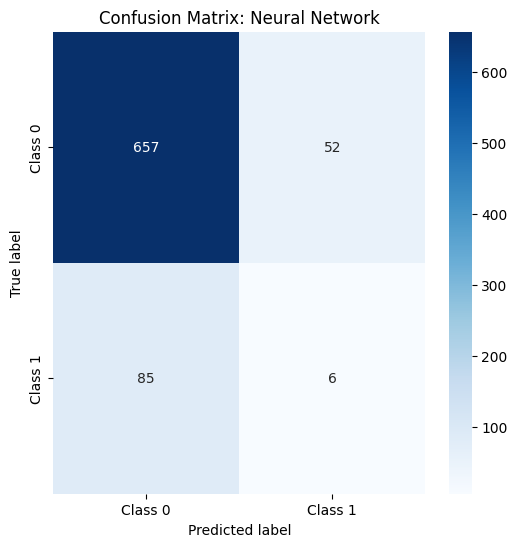

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# Function to compute metrics and plot confusion matrix
def compute_metrics_with_plot(y_true, y_pred, y_prob=None, description=""):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0    # Positive Predictive Value
    gini_index = 2 * roc_auc_score(y_true, y_prob) - 1 if y_prob is not None else "N/A"
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else "N/A"
    mer = 1 - accuracy  # Misclassification Error Rate

    # Print metrics
    print(f"\nMetrics for {description}:")
    print("Accuracy:", round(accuracy, 3))
    print("Sensitivity (TPR):", round(sensitivity, 3))
    print("Specificity (TNR):", round(specificity, 3))
    print("Precision (PPV):", round(precision, 3))
    print("Gini Index:", gini_index)
    print("AUC:", auc)
    print("MER:", round(mer, 3))
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("=" * 50)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, classes=["Class 0", "Class 1"], title=f"Confusion Matrix: {description}")

# Decision Tree Evaluation
dt_model = decision_tree_model(X_train_scaled, X_test_scaled, y_train, y_test)
dt_pred = dt_model.predict(X_test_scaled)
dt_prob = dt_model.predict_proba(X_test_scaled)[:, 1] if hasattr(dt_model, "predict_proba") else None
compute_metrics_with_plot(y_test, dt_pred, dt_prob, "Decision Tree")

# Neural Network Evaluation
nn_model = neural_network_model(X_train_nn, X_test_nn, y_train, y_test, input_dim, threshold=0.3)
nn_prob = nn_model.predict(X_test_nn).flatten()
nn_pred = (nn_prob >= 0.3).astype(int)
compute_metrics_with_plot(y_test, nn_pred, nn_prob, "Neural Network")


NameError: name 'nn_prob' is not defined


--- Metrics for Voting Ensemble ---

Metrics for Voting Ensemble:
Accuracy: 0.879
Sensitivity: 0.011
Specificity: 0.99
Precision: 0.125
Gini Index: N/A
AUC: N/A
MER: 0.121


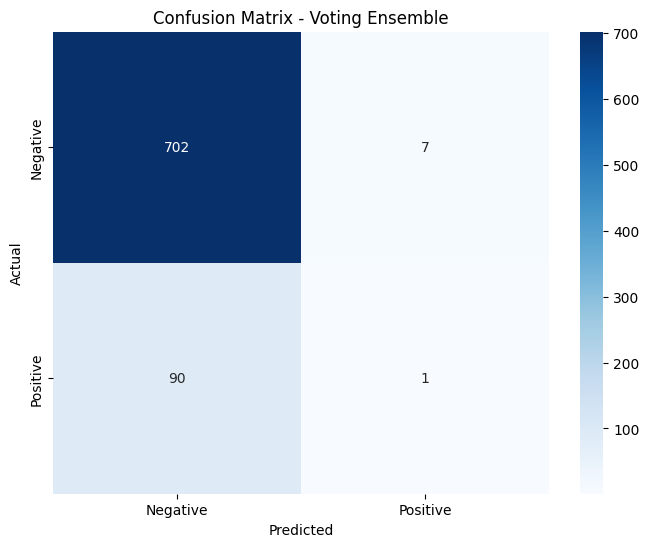

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Ensemble Function using Voting
def voting_ensemble(y_pred_nn, y_pred_dt, y_true):
    """
    Ensemble predictions using majority voting.

    Args:
        y_pred_nn (np.ndarray): Predictions from Neural Network.
        y_pred_dt (np.ndarray): Predictions from Decision Tree.
        y_true (np.ndarray): True labels.

    Returns:
        y_pred_ensemble (np.ndarray): Final predictions after voting.
    """
    # Stack predictions for each sample
    combined_predictions = np.vstack([y_pred_nn, y_pred_dt]).T

    # Take majority vote for final prediction
    y_pred_ensemble = mode(combined_predictions, axis=1).mode.flatten()

    # Compute and display metrics
    print("\n--- Metrics for Voting Ensemble ---")
    compute_metrics(y_true, y_pred_ensemble, description="Voting Ensemble")

    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred_ensemble, title="Confusion Matrix - Voting Ensemble")

    return y_pred_ensemble

# Ensemble the models using Voting
ensemble_pred_voting = voting_ensemble(nn_pred, dt_pred, y_test)
